# Análisis de sentimiento

## 1. Importación de librerías y revisión del *dataframe*

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pysentimiento import create_analyzer #para el analisis de sentimiento
from factor_analyzer import FactorAnalyzer #para hacer ACP

ModuleNotFoundError: No module named 'pysentimiento'

Noten que vamos a usar una librería llamada `pysentimiento`, que funciona con base en un modelo llamado ROBERTuito. Pueden leer más sobre ello [en este paper](https://arxiv.org/abs/2106.09462).

In [2]:
base=pd.read_csv('rawdata/clases/habitaclia5467_ejercicio3-1y2.csv')

['Unnamed: 0', 'OBJECTID', 'codigo_inmueble1', 'Title', 'Type_build', 'Type_opera', 'Link', 'Location', 'Lat_X', 'Lon_Y', 'Climatic_Z', 'Nom_Mun', 'precio_eur', 'superficie', 'superficie2', 'Unit_price', 'Ln_total_pr', 'Ln_unit_pr', 'numero_habitaciones', 'numero_bano', 'ratio_bano_hab', 'numero_aseo', 'ascensor', 'interac_planta', 'numero_de_piso', 'anyo_constr_ponderad', 'antig_ponderad', 'Inverse_Age', 'Year_Before_1981', 'Year_1982_2006', 'Year_After_2007', 'superficie_terraza_m2', 'grand_terr_20m2', 'superficie_jardin_m2', 'superficie_salon', 'bool_despacho', 'bool_buhardilla', 'bool_trastero', 'bool_lavadero', 'bool_piscina_comunitaria', 'bool_jardin_comunitario', 'bool_amueblado', 'bool_ascensor', 'descripcion', 'bool_aire_acondicionado', 'bool_calefaccion', 'bool_chimenea', 'texto_destacado', 'Description', 'calificacion_consumo_letra', 'calificacion_consumo_valor', 'calificacion_emision_letra', 'calificacion_emision_valor', 'Dum_EPC', 'EPC_A_emision', 'EPC_B_emision', 'EPC_C_e

## 2. Análisis de sentimiento

La columna `cl_descrip` es aquella que tiene las descripciones sobre las que queremos realizar el análisis de sentimiento.

In [36]:
# Crear el analizador de sentimientos
analyzer = create_analyzer(task="sentiment", lang="es")

# Aplicar el análisis de sentimientos a todas las filas de la columna 'Description'
sentiments = base['cl_descrip'].apply(analyzer.predict)

# Extraer los valores de probabilidad para cada categoría y crear las nuevas columnas
base['POS'] = [result.probas.get('POS', 0) for result in sentiments]
base['NEU'] = [result.probas.get('NEU', 0) for result in sentiments]
base['NEG'] = [result.probas.get('NEG', 0) for result in sentiments]

In [37]:
base[['cl_descrip','POS','NEU','NEG']].head()

,cl_descrip,POS,NEU,NEG
0,"Piso reformado de 4 habitaciones, salón comedo...",0.634861,0.352537,0.012602
1,"BENET MATEU, PISO DE ORIGEN CON MUY BUENA DIST...",0.736040,0.250749,0.013210
2,Apartamento pero con acceso independiente desd...,0.788073,0.200277,0.011651
3,"PISAZO, EL MEJOR DE LA ZONA.FENOMENAL PISO SIN...",0.965982,0.029098,0.004920
4,VIVIENDA EN LA CALLE GARROFER DE SANT IDELFONS...,0.405443,0.552446,0.042112


En este momento, recomiendo abrir el documento en Excel y ver qué tal ha quedado y si hay algo que se nos esté pasando.

In [ ]:
#base[['cl_descrip','POS','NEU','NEG']].to_excel('rawdata/clases/sentimiento_borrar_luego.xlsx')

Lo que me encuentro es que hay celdas con descripción vacía (`cantidad_palabras`, una columna que habíamos creado en el cuaderno anterior, tiene valores 0), pero en donde se han ponderado los sentimientos. Creo que es algo que deberíamos mejorar. 

Me parece que aquellas que no tienen descripción es porque deberían tener un sentimiento negativo asociado, pero no deberían tener nada de positivo ni de neutral. Si fuese así, ¿qué valor `NEG` le deberíamos poner? Podría ser el valor promedio, siempre que la distribución de la variable sea normal. Empecemos revisando eso.

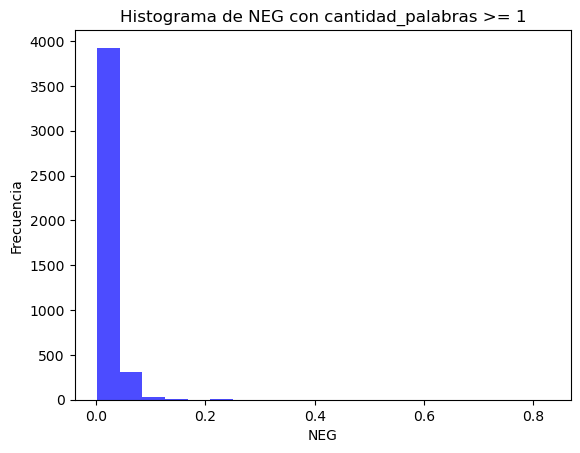

In [50]:
# Filtra el DataFrame para incluir solo las filas donde 'cantidad_palabras' es mayor o igual que 1
filtered_df = base[base['cantidad_palabras'] >= 1]

# Crea el histograma de la columna 'NEG' en el DataFrame filtrado
plt.hist(filtered_df['NEG'], bins=20, color='blue', alpha=0.7)
plt.xlabel('NEG')
plt.ylabel('Frecuencia')
plt.title('Histograma de NEG con cantidad_palabras >= 1')
plt.show()

Como no es una distribución normal, usar el promedio no capturaría la distribución de los datos. En esos casos, es preferible **usar la mediana**: el valor que está justo en el centro de los datos.

Ahora sí arreglemos los valores de esas filas.

In [52]:
#Obtengo la mediana
median_neg = filtered_df['NEG'].median() #noten que lo hago sobre 'filtered_df'

# Función para actualizar 'POS', 'NEU' y 'NEG' cuando la cantidad de palabras es igual a 0
def update_sentiment_values(row):
    if row['cantidad_palabras'] == 0:
        row['POS'] = 0
        row['NEU'] = 0
        row['NEG'] = median_neg
    return row

# Aplica la función a cada fila del DataFrame
base = base.apply(update_sentiment_values, axis=1)

# Si quieren, pueden exportar para explorar los resultados 
#base[['cl_descrip','POS','NEU','NEG']].to_excel('rawdata/sentimiento_borrar_luego.xlsx')

## 5. Análisis de Componentes Principales

Con el análisis hecho, notamos que tenemos tres nuevas variables. Podríamos intentar hacer un ACP para ver si es posible tener una sola variable que las sintetice.

In [53]:
#Le indicamos en qué columnas se va a centrar
df = base[['POS','NEU','NEG']]

#Le pedimos un ACP con rotación varimax y N factores
fa = FactorAnalyzer(rotation='varimax', 
                    n_factors=3, ## esto lo indican ustedes, deben ir probando ## 
                    method='principal')
fa.fit(df)

# Obtener la varianza total explicada
total_variance = fa.get_factor_variance()

# Crear un DataFrame para mostrar la tabla de la varianza total explicada
explained_variance_df = pd.DataFrame(total_variance, 
                                     columns=['Factor1', 'Factor2',
                                              'Factor3'], #Deben aumentar o disminuir según la 
                                                          #cantidad de factores que 
                                                          #hayan indicado
                                     index=['SS Loadings', 'Proportion Var', 'Cumulative Var'])

#Esto es solo para que la tabla se vea mejor
explained_variance_df = explained_variance_df.transpose()

print("Tabla de Varianza Total Explicada:")
print(explained_variance_df)

Tabla de Varianza Total Explicada:
          SS Loadings  Proportion Var  Cumulative Var
Factor1  1.923330e+00    6.411101e-01         0.64111
Factor2  1.076670e+00    3.588899e-01         1.00000
Factor3  1.760636e-14    5.868786e-15         1.00000


Fíjense siempre en *Cumulative Var*, que es la varianza acumulada explicada. Noto que a partir del segundo factor ya explico un 100% de las tres variables. 

Ahora tratemos de interpretar cada factor.

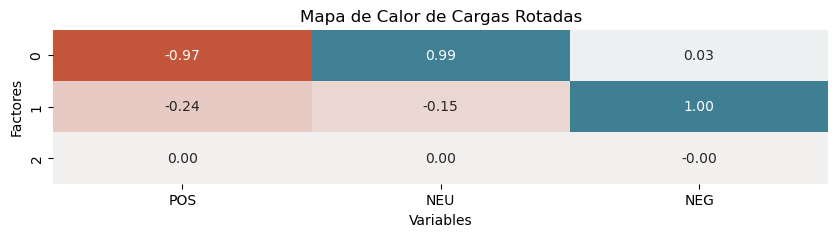

In [54]:
#Creamos una matriz de cargas rotadas
rotated_loadings = fa.loadings_

# Transponer la matriz de cargas rotadas para que las columnas coincidan con las variables
rotated_loadings_transposed = rotated_loadings.T

rotated_df = pd.DataFrame(rotated_loadings_transposed, columns=df.columns)

# Definir los colores para el mapa de calor
cmap = sns.diverging_palette(20, 220, as_cmap=True)

# Crear el mapa de calor
plt.figure(figsize=(10, 2)) #Altura y ancho, lo pueden variar
sns.heatmap(rotated_df, cmap=cmap, annot=True, fmt=".2f", cbar=False, vmin=rotated_df.min().min(), vmax=rotated_df.max().max())
plt.title('Mapa de Calor de Cargas Rotadas')
plt.xlabel('Variables')
plt.ylabel('Factores')
plt.show()

El primer factor (`0`) es totalmente neutral y para nada positivo. Mientras que el segundo (`1`), es totalmente negativo.

In [55]:
# Obtener los factores extraídos
factors = fa.transform(df)

# Agregar los factores al DataFrame original
base['Sent_NEU_noPOS'] = factors[:, 0] #Este es el número que me interesa
base['Sent_NEG'] = factors[:, 1] #Este es el número que me interesa

In [56]:
base.to_csv('rawdata/clases/habitaclia5467_ejercicio3-3.csv')